# Read in the data

In [1]:
import pandas
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pandas.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pandas.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pandas.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pandas.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pandas.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pandas.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pandas.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pandas.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
survey_sat_corr = correlations[survey_fields]
survey_sat_corr.dropna(inplace=True)
survey_sat_corr

rr_s          0.232199
rr_t         -0.023386
rr_p          0.047925
N_s           0.423463
N_t           0.291463
N_p           0.421530
saf_p_11      0.122913
com_p_11     -0.115073
eng_p_11      0.020254
aca_p_11      0.035155
saf_t_11      0.313810
com_t_11      0.082419
aca_t_11      0.132348
saf_s_11      0.337639
com_s_11      0.187370
eng_s_11      0.213822
aca_s_11      0.339435
saf_tot_11    0.318753
com_tot_11    0.077310
eng_tot_11    0.100102
aca_tot_11    0.190966
Name: sat_score, dtype: float64

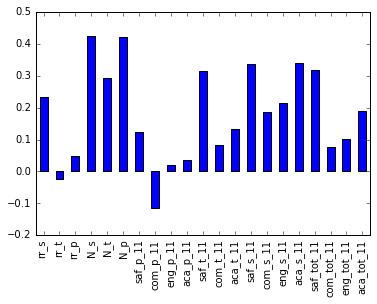

In [12]:
survey_sat_corr.plot.bar()
plt.show()

The plot above shows the correlation coefficient of various fields in the survey dataframe with sat scores. It shows that there is a high correlation between the safety score from students and teachers and SAT scores. There is also a good correlation between academic expectation of students and SAT scores.

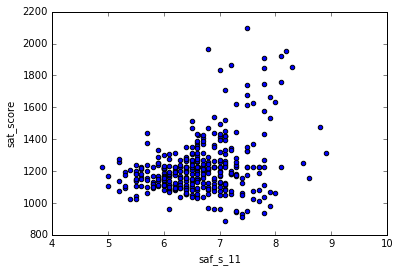

In [13]:
combined.plot.scatter('saf_s_11','sat_score')
plt.show()

The above plot shows a decent correlation between safety scores by students and SAT scores. Students who feel their school is safe tend to do well in the SAT while a majority of those who rated their school just above average in safety scores tedn to perform relatively poorly.


In [14]:
combined.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,0,129.028846,197.038462,...,Then to New York City residents,0,0,0,0,0,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.713764,-73.985260,01
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.000000,49.000000,...,0,0,0,0,0,0,"200 Monroe Street\nNew York, NY 10002\n(40.712...",40.712332,-73.984797,01
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.000000,21.000000,...,0,0,0,0,0,0,"420 East 12 Street\nNew York, NY 10009\n(40.72...",40.729783,-73.983041,01
3,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0,0,129.028846,197.038462,...,0,0,0,0,0,0,"145 Stanton Street\nNew York, NY 10002\n(40.72...",40.720569,-73.985673,01
4,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",159,522.0,574.0,525.0,1621.0,"NEW EXPLORATIONS SCI,TECH,MATH",255.000000,377.000000,...,0,0,0,0,0,0,"111 Columbia Street\nNew York, NY 10002\n(40.7...",40.718725,-73.979426,01


In [15]:
saf_s_by_dist = combined.groupby('school_dist').agg(numpy.mean)[['saf_s_11', 'lat', 'lon']]
saf_s_by_dist.reset_index(inplace=True)
saf_s_by_dist

,school_dist,saf_s_11,lat,lon
0,01,6.768611,40.719022,-73.982377
1,02,6.910660,40.739699,-73.991386
2,03,6.716667,40.781574,-73.977370
3,04,6.885714,40.793449,-73.943215
4,05,6.314286,40.817077,-73.949251
5,06,6.950000,40.848970,-73.932502
6,07,6.800000,40.816815,-73.919971
7,08,6.364697,40.823803,-73.866087
8,09,6.655000,40.836349,-73.906240
9,10,6.577273,40.870345,-73.898360


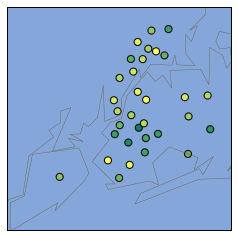

In [16]:
from mpl_toolkits.basemap import Basemap
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)
longitudes = saf_s_by_dist['lon'].tolist()
latitudes = saf_s_by_dist['lat'].tolist()
m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=saf_s_by_dist['saf_s_11'], cmap='summer')
m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
plt.show()

From the above map, it can be observed that Brooklyn and Manhattan districts  generally have higher school safety scores compared to the rest of New York City. Also districts with low school safety scores are frequent in Brooklyn

In [17]:
race_with_sat_corr =correlations[['white_per',\
                                  'asian_per','black_per','hispanic_per']]
race_with_sat_corr

white_per       0.620718
asian_per       0.570730
black_per      -0.284139
hispanic_per   -0.396985
Name: sat_score, dtype: float64

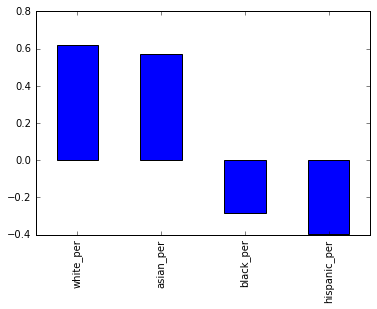

In [18]:
race_with_sat_corr.plot.bar()

The above bar plot shows that schools with higher number of white and asian students have a positive correlation with sat scores while schools with higher number of black and hispanics have negative correlation with SAT scores. This could mean that whites and asians generally tend to do better in SAT than other races.

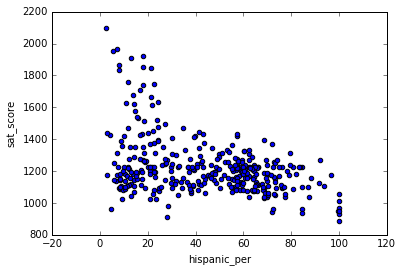

In [19]:
combined.plot.scatter('hispanic_per','sat_score')
plt.show()

The above plot shows that schools with higher number of hispanic students tend to do poorly in SAT while schools with lower number of hispanics fair much better in SAT.

In [20]:
combined[['hispanic_per', 'sat_score']]

,hispanic_per,sat_score
0,53.8,1122.000000
1,45.9,1172.000000
2,55.4,1149.000000
3,56.9,1207.000000
4,14.2,1621.000000
5,18.2,1856.000000
6,59.2,1182.000000
7,47.6,1194.000000
8,60.6,1156.000000
9,66.1,1111.000000


In [21]:
hisp_school_gt_95 = combined[combined['hispanic_per'] > 95]
hisp_school_gt_95

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
44,02M542,MANHATTAN BRIDGES HIGH SCHOOL,66,336.0,378.0,344.0,1058.0,Manhattan Bridges High School,67.000000,102.000000,...,0,0,0,0,0,0,"525 West 50Th Street\nNew York, NY 10019\n(40....",40.765027,-73.992517,02
82,06M348,WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL,70,380.0,395.0,399.0,1174.0,0,129.028846,197.038462,...,Then to New York City residents,0,0,0,0,0,"511 West 182Nd Street\nNew York, NY 10033\n(40...",40.848879,-73.930807,06
89,06M552,GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...,56,339.0,349.0,326.0,1014.0,GREGORIO LUPERON HS SCI & MATH,88.000000,138.000000,...,0,0,0,0,0,0,"501 West 165Th\nNew York, NY 10032\n(40.838032...",40.838032,-73.938371,06
125,09X365,ACADEMY FOR LANGUAGE AND TECHNOLOGY,54,315.0,339.0,297.0,951.0,Academy for Language and Technology,20.000000,20.000000,...,0,0,0,0,0,0,"1700 Macombs Road\nBronx, NY 10453\n(40.849102...",40.849102,-73.916088,09
141,10X342,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,49,300.0,333.0,301.0,934.0,International School for Liberal Arts,55.000000,73.000000,...,0,0,0,0,0,0,"2780 Reservoir Avenue\nBronx, NY 10468\n(40.87...",40.870377,-73.898163,10
176,12X388,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE,30,321.0,351.0,298.0,970.0,0,129.028846,197.038462,...,0,0,0,0,0,0,"1300 Boynton Avenue\nBronx, NY 10472\n(40.8313...",40.831366,-73.878823,12
253,19K583,MULTICULTURAL HIGH SCHOOL,29,279.0,322.0,286.0,887.0,Multicultural High School,44.000000,44.000000,...,0,0,0,0,0,0,"999 Jamaica Avenue\nBrooklyn, NY 11208\n(40.69...",40.691144,-73.868426,19
286,24Q296,PAN AMERICAN INTERNATIONAL HIGH SCHOOL,55,317.0,323.0,311.0,951.0,0,129.028846,197.038462,...,0,0,0,0,0,0,"45-10 94Th Street\nElmhurst, NY 11373\n(40.743...",40.743303,-73.870575,24


In [22]:
hisp_sch_lt_10 = combined[combined['hispanic_per'] < 10]
hisp_gt_1000 = hisp_sch_lt_10[hisp_sch_lt_10['sat_score'] > 1000]
hisp_gt_1000

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
37,02M475,STUYVESANT HIGH SCHOOL,832,679.000000,735.000000,682.000000,2096.000000,STUYVESANT HS,1510.000000,2819.000000,...,0,0,0,0,0,0,"345 Chambers Street\nNew York, NY 10282\n(40.7...",40.717746,-74.014049,02
46,02M545,HIGH SCHOOL FOR DUAL LANGUAGE AND ASIAN STUDIES,78,412.000000,581.000000,431.000000,1424.000000,High School for Dual Language and Asian Studies,61.000000,96.000000,...,0,0,0,0,0,0,"350 Grand Street\nNew York, NY 10002\n(40.7168...",40.716867,-73.989532,02
151,10X445,BRONX HIGH SCHOOL OF SCIENCE,731,632.000000,688.000000,649.000000,1969.000000,BRONX HS OF SCIENCE,1190.000000,2435.000000,...,0,0,0,0,0,0,"75 West 205 Street\nBronx, NY 10468\n(40.87705...",40.877056,-73.889780,10
187,13K430,BROOKLYN TECHNICAL HIGH SCHOOL,1277,587.000000,659.000000,587.000000,1833.000000,BROOKLYN TECHNICAL HS,2117.000000,3692.000000,...,0,0,0,0,0,0,"29 Ft Greene Place\nBrooklyn, NY 11217\n(40.68...",40.688107,-73.976745,13
192,13K595,BEDFORD ACADEMY HIGH SCHOOL,89,438.000000,443.000000,431.000000,1312.000000,Bedford Academy High School,43.000000,57.000000,...,0,0,0,0,0,0,"1119 Bedford Avenue\nBrooklyn, NY 11216\n(40.6...",40.685381,-73.954268,13
194,13K670,BENJAMIN BANNEKER ACADEMY,185,471.000000,472.000000,448.000000,1391.000000,BENJAMIN BANNEKER ACADEMY,132.000000,149.000000,...,0,0,0,0,0,0,"71-77 Clinton Avenue\nBrooklyn, NY 11205\n(40....",40.695662,-73.969286,13
220,16K455,BOYS AND GIRLS HIGH SCHOOL,131,365.000000,370.000000,362.000000,1097.000000,BOYS AND GIRLS HS,22.000000,32.000000,...,0,0,0,0,0,0,"1700 Fulton Street\nBrooklyn, NY 11213\n(40.67...",40.679433,-73.932432,16
223,17K382,ACADEMY FOR COLLEGE PREPARATION AND CAREER EXP...,59,396.000000,374.000000,369.000000,1139.000000,Academy for College Preparation and Career Exp...,64.000000,82.000000,...,0,0,0,0,0,0,"911 Flatbush Avenue\nBrooklyn, NY 11226\n(40.6...",40.649440,-73.958431,17
226,17K528,THE HIGH SCHOOL FOR GLOBAL CITIZENSHIP,46,403.000000,385.000000,388.000000,1176.000000,"High School for Global Citizenship, The",20.000000,34.000000,...,0,0,0,0,0,0,"883 Classon Avenue\nBrooklyn, NY 11225\n(40.67...",40.670299,-73.961648,17
227,17K531,"SCHOOL FOR HUMAN RIGHTS, THE",35,348.000000,381.000000,359.000000,1088.000000,0,129.028846,197.038462,...,Then to New York City residents,0,0,0,0,0,"600 Kingston Avenue\nBrooklyn, NY 11203\n(40.6...",40.659517,-73.942546,17


In [23]:
gender_sat_corr = correlations[['male_per','female_per']]
gender_sat_corr

male_per     -0.112062
female_per    0.112108
Name: sat_score, dtype: float64

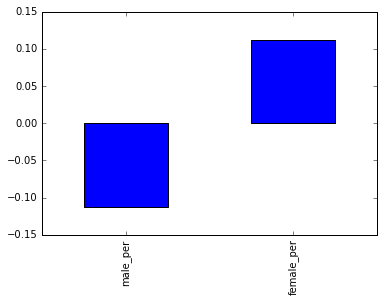

In [24]:
gender_sat_corr.plot.bar()

The above plot indicated that schools with higher number of female students correlates positively with high SAT scores while schools with higher number of male students correlated negatively with SAT scores. This may indicate that schools with a alrge female population do well in SAt whileschools with large male population do poorly in SAT.

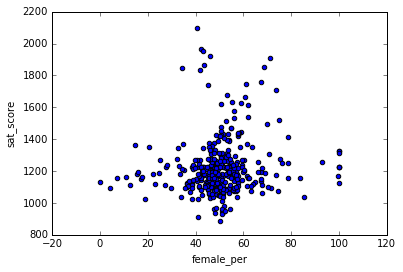

In [25]:
combined.plot.scatter('female_per','sat_score')
plt.show()

Schools with a higher female population generally tend to do well in SAT. The schools with the highest and lowest SAT scores are those whose population is around 50% female.

In [26]:
fem_gt_60 = combined[combined['female_per'] > 0.6]
fem_sat_gt_1700 = fem_gt_60[fem_gt_60['sat_score'] > 1700]
fem_sat_gt_1700

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
5,01M696,BARD HIGH SCHOOL EARLY COLLEGE,130,624.0,604.0,628.0,1856.0,0,129.028846,197.038462,...,0,0,0,0,0,0,"525 East Houston Street\nNew York, NY 10002\n(...",40.718962,-73.976066,01
26,02M416,ELEANOR ROOSEVELT HIGH SCHOOL,127,572.0,594.0,592.0,1758.0,Eleanor Roosevelt High School,155.000000,235.000000,...,0,0,0,0,0,0,"411 East 76 Street\nNew York, NY 10021\n(40.77...",40.770116,-73.953379,02
37,02M475,STUYVESANT HIGH SCHOOL,832,679.0,735.0,682.0,2096.0,STUYVESANT HS,1510.000000,2819.000000,...,0,0,0,0,0,0,"345 Chambers Street\nNew York, NY 10282\n(40.7...",40.717746,-74.014049,02
60,03M479,BEACON HIGH SCHOOL,261,577.0,575.0,592.0,1744.0,BEACON SCHOOL,166.000000,197.000000,...,0,0,0,0,0,0,"227-243 West 61St Street\nNew York, NY 10023\n...",40.772158,-73.987797,03
61,03M485,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...,531,566.0,564.0,577.0,1707.0,FIORELLO H.LAGUARDIA HS,691.000000,1236.000000,...,0,0,0,0,0,0,"100 Amsterdam Avenue\nNew York, NY 10023\n(40....",40.773671,-73.985269,03
79,05M692,"HIGH SCHOOL FOR MATHEMATICS, SCIENCE AND ENGIN...",101,605.0,654.0,588.0,1847.0,HIGH SCHOOL FOR MATH SCIENCE ENGINEERING @ CCNY,114.000000,124.000000,...,0,0,0,0,0,0,"240 Convent Ave\nNew York, NY 10031\n(40.82112...",40.821123,-73.948845,05
151,10X445,BRONX HIGH SCHOOL OF SCIENCE,731,632.0,688.0,649.0,1969.0,BRONX HS OF SCIENCE,1190.000000,2435.000000,...,0,0,0,0,0,0,"75 West 205 Street\nBronx, NY 10468\n(40.87705...",40.877056,-73.889780,10
155,10X696,HIGH SCHOOL OF AMERICAN STUDIES AT LEHMAN COLLEGE,92,636.0,648.0,636.0,1920.0,HIGH SCHOOL OF AMERICAN STUDIES At Lehman College,194.000000,302.000000,...,0,0,0,0,0,0,"2925 Goulden Avenue\nBronx, NY 10468\n(40.8712...",40.871255,-73.897516,10
187,13K430,BROOKLYN TECHNICAL HIGH SCHOOL,1277,587.0,659.0,587.0,1833.0,BROOKLYN TECHNICAL HS,2117.000000,3692.000000,...,0,0,0,0,0,0,"29 Ft Greene Place\nBrooklyn, NY 11217\n(40.68...",40.688107,-73.976745,13
198,14K449,"BROOKLYN LATIN SCHOOL, THE",72,586.0,584.0,570.0,1740.0,0,129.028846,197.038462,...,0,0,0,0,0,0,"223 Graham Avenue\nBrooklyn, NY 11206\n(40.709...",40.709900,-73.943660,14


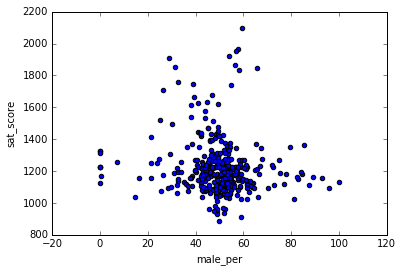

In [27]:
combined.plot.scatter('male_per','sat_score')
plt.show()

In [28]:
combined['ap_per'] = combined['AP Test Takers ']/combined['total_enrollment']
combined

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist,ap_per
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.000000,404.000000,363.000000,1122.000000,0,129.028846,197.038462,...,0,0,0,0,0,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.713764,-73.985260,01,0.305756
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.000000,423.000000,366.000000,1172.000000,UNIVERSITY NEIGHBORHOOD H.S.,39.000000,49.000000,...,0,0,0,0,0,"200 Monroe Street\nNew York, NY 10002\n(40.712...",40.712332,-73.984797,01,0.098985
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.000000,402.000000,370.000000,1149.000000,EAST SIDE COMMUNITY HS,19.000000,21.000000,...,0,0,0,0,0,"420 East 12 Street\nNew York, NY 10009\n(40.72...",40.729783,-73.983041,01,0.031773
3,01M509,MARTA VALLE HIGH SCHOOL,44,390.000000,433.000000,384.000000,1207.000000,0,129.028846,197.038462,...,0,0,0,0,0,"145 Stanton Street\nNew York, NY 10002\n(40.72...",40.720569,-73.985673,01,0.351577
4,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",159,522.000000,574.000000,525.000000,1621.000000,"NEW EXPLORATIONS SCI,TECH,MATH",255.000000,377.000000,...,0,0,0,0,0,"111 Columbia Street\nNew York, NY 10002\n(40.7...",40.718725,-73.979426,01,0.158091
5,01M696,BARD HIGH SCHOOL EARLY COLLEGE,130,624.000000,604.000000,628.000000,1856.000000,0,129.028846,197.038462,...,0,0,0,0,0,"525 East Houston Street\nNew York, NY 10002\n(...",40.718962,-73.976066,01,0.209123
6,02M047,47 THE AMERICAN SIGN LANGUAGE AND ENGLISH SECO...,16,395.000000,400.000000,387.000000,1182.000000,0,129.028846,197.038462,...,0,0,0,0,0,"223 East 23 Street\nNew York, NY 10010\n(40.73...",40.738599,-73.982512,02,0.741545
7,02M288,FOOD AND FINANCE HIGH SCHOOL,62,409.000000,393.000000,392.000000,1194.000000,0,129.028846,197.038462,...,0,0,0,0,0,"525 West 50Th Street\nNew York, NY 10019\n(40....",40.765027,-73.992517,02,0.297988
8,02M294,ESSEX STREET ACADEMY,53,394.000000,384.000000,378.000000,1156.000000,0,129.028846,197.038462,...,0,0,0,0,0,"350 Grand Street\nNew York, NY 10002\n(40.7168...",40.716867,-73.989532,02,0.376177
9,02M296,HIGH SCHOOL OF HOSPITALITY MANAGEMENT,58,374.000000,375.000000,362.000000,1111.000000,High School of Hospitality Management,129.028846,197.038462,...,0,0,0,0,0,"525 West 50Th Street\nNew York, NY 10019\n(40....",40.765027,-73.992517,02,0.307945


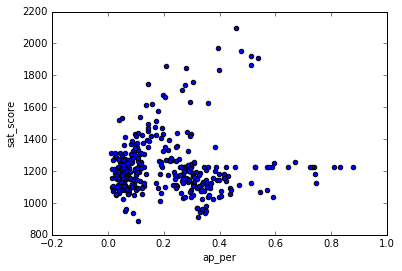

In [29]:
combined.plot.scatter('ap_per','sat_score')
plt.show()

The above plot shows a weak positive correlation  between SAT scores and percentage of students that take AP tests. schools with students that score above 1000 in SAT generally takes AP test while those with 